In [1]:
from pymatgen.ext.matproj import MPRester
from pymatgen.electronic_structure.plotter import BSPlotter
import numpy as np
from pymatgen import Structure
import matplotlib.pyplot as plt
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

In [2]:
with MPRester("KCN5RO8FHahQJZKZ") as m:

    LiZnP = m.get_bandstructure_by_material_id("mp-10182")

# **Détermination de la bande interdite**

<module 'matplotlib.pyplot' from '/usr/local/lib64/python3.6/site-packages/matplotlib/pyplot.py'>

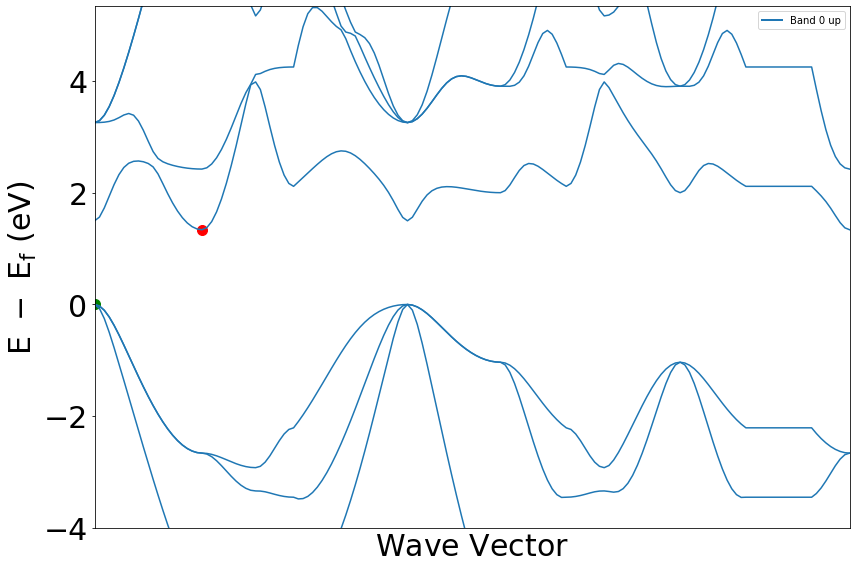

In [3]:
plot = BSPlotter(LiZnP)
plot.get_plot(vbm_cbm_marker=True)

In [4]:
print(LiZnP.get_band_gap())

{'direct': False, 'energy': 1.3386, 'transition': '(0.000,0.000,0.000)-(0.500,0.000,0.500)'}


Le gap est ici indirect avec une largeur de bande interdite de 1.3386 eV.<br>
Il s'agit donc d'un semi-conducteur. <br>
La transition se fait selon (0.000,0.000,0.000)-(0.500,0.000,0.500). 
Le point en rouge est la base de la première bande de conduction et le point vert est le sommet de la dernière bande de valence. 

# **La direction dans laquelle la dernière (première) bande de valence (conduction) présente le plus et le moins de dispersion**

In [5]:
#list of the indices of the band containing the VBM 
cond_liste = []
cond_band  = LiZnP.get_cbm()

#list of the indices of the band containing the CBM 
val_band_liste = []
val_band = LiZnP.get_vbm() 

for elem in cond_band["band_index"].items():
    cond_band_liste = elem[1]

for elem in val_band["band_index"].items():
    val_band_liste = elem[1]
    
vbm_index = val_band_liste[-1]
cbm_index = cond_band_liste[0]
print("La première bande de conduction a l'indice : "+str(cbm_index)+".")   
print("La dernière bande de valence a l'indice : "+str(vbm_index)+".")

La première bande de conduction a l'indice : 10.
La dernière bande de valence a l'indice : 9.


144
144
2.116


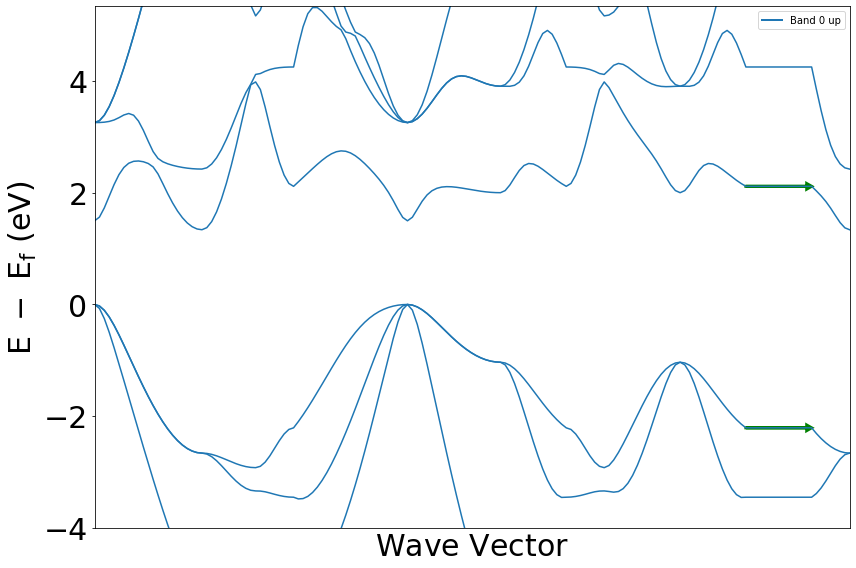

In [7]:
def plot_dispersion(bands):
    data = BSPlotter(bands).bs_plot_data()
    energies = data.get('energy').get('1')    
    energies_vbm = energies[0][vbm_index]
    energies_cbm = energies[0][cbm_index]
    distances = data['distances'][0]

    #indices = np.unique(np.array(data.get('ticks').get('distance')))
    #step = indices[1:] - indices[:-1]
    valence_slope = np.empty(len(energies_vbm)-1)
    conduction_slope = np.empty(len(energies_cbm)-1)
    for i in range(len(energies_vbm)-1):
        if((distances[i+1]- distances[i]) ==0):
            valence_slope[i] = 10.0
        else: 
            valence_slope[i] = (energies_vbm[i+1] - energies_vbm[i])/ (distances[i+1]- distances[i])
            conduction_slope[i] = (energies_cbm[i+1] - energies_cbm[i])/ (distances[i+1]- distances[i])
    valence_min_index = np.argmin(abs(valence_slope))
    conduction_min_index = np.argmin(abs(conduction_slope))
    plot = BSPlotter(bands).get_plot()
    plt.arrow(distances[valence_min_index], energies_vbm[valence_min_index], distances[valence_min_index+1]-distances[valence_min_index], energies_vbm[valence_min_index+1]-energies_vbm[valence_min_index], head_width=0.10, head_length=0.05, linewidth=3, color='g', length_includes_head=True)
    plt.arrow(distances[conduction_min_index], energies_cbm[conduction_min_index], distances[conduction_min_index+1]-distances[conduction_min_index], energies_cbm[conduction_min_index+1]-energies_cbm[conduction_min_index], head_width=0.10, head_length=0.05, linewidth=3, color='g', length_includes_head=True)
    plt.show()

plot_dispersion(LiZnP)

# **Calcule de la masse effective au sommet (base) de la dernière (première) bande de valence (conduction) en supposant une dispersion parabolique**

Pour trouver la masse effective, il faut partir de l'équation : 
$$m_* = \frac{\hbar^2}{\frac{\mathrm d^2}{\mathrm d k^2} \left( E \right)}$$

où h_bar = 6.626e-34/(2*pi) 

Etant donné que ma molécule ne contient qu'un seul chemin, je ne suis pas parvenue à exploiter l'hypothèse selon laquelle la dispersion est parabolique. 

Puisque la dispersion est parabolique: de la forme a*x^2 + b*x + c, la dérivée seconde est alors juste 2*a. 

Il faut donc effectuer une régression polynomiale de degré 2 et prendre le premier coefficient afin de calculer la masse effective.  